In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision

from iobs.simulators import make_n_disk
from iobs.layers import IOBLayer
from iobs.models import BaseAE

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)

Device: mps


# Generate dataset

In [3]:
# generate images
dim = 32
data = make_n_disk(
    n_samples=10000,
    n_disks=2,
    dim=dim,
    verbose=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28073.40it/s]


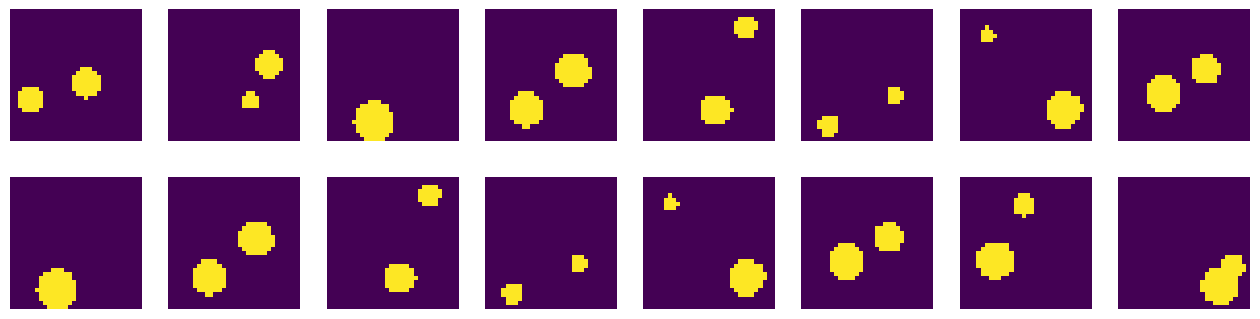

In [4]:
# plot examples
N, M = 2,8
f, axs = plt.subplots(N, M, figsize=(2*M, 2*N))

inds = np.random.choice(len(data), size=N*M, replace=False)
for i in range(N):
    for j in range(M):
        axs[i,j].imshow(data[inds[i*N+j]])
        axs[i,j].axis('off')

In [5]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [6]:
# create dataset and dataloaders
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5, 0.5)]
)
itransform = torchvision.transforms.Normalize(-0.5, 2)
class SimulatedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx]

train_dataset = SimulatedDataset(data[in_train], transform=transform)
val_dataset = SimulatedDataset(data[in_val], transform=transform)
test_dataset = SimulatedDataset(data[in_test], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define encoder-decoder architecture

In [7]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a convolutional encoder
encoder = nn.Sequential(
    nn.Conv2d(1, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(12, 24, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(24, 48, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Flatten(),
    *(build_dense_sequence([768, 256, 128, 16])),
).to(device)

# define a convolutional decoder
decoder = nn.Sequential(
    *(build_dense_sequence([16, 128, 256, 768])),
    nn.Unflatten(dim=1,
                 unflattened_size=(48, 4, 4)),
    nn.ConvTranspose2d(48, 24, 4,
                       stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),
).to(device)

# define a IOB with a max width of 16 features
bottleneck = IOBLayer(16, device=device)

In [8]:
# build a simple autoencoder model
model = BaseAE(
    input_shape=(dim, dim),
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [9]:
# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

# Train

In [10]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 5e-5

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [11]:
trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()
    trloss = trloss / len(train_loader)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()
        valoss = valoss / len(val_loader)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    print(f"epoch : {epoch + 1}/{max_epochs}, "
          f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

epoch : 1/3000, loss = 0.691005, val loss = 0.519451
epoch : 2/3000, loss = 0.377201, val loss = 0.329727
epoch : 3/3000, loss = 0.315043, val loss = 0.306326
epoch : 4/3000, loss = 0.299638, val loss = 0.295526
epoch : 5/3000, loss = 0.289931, val loss = 0.285986
epoch : 6/3000, loss = 0.281128, val loss = 0.279249
epoch : 7/3000, loss = 0.276658, val loss = 0.276902
epoch : 8/3000, loss = 0.275126, val loss = 0.275317
epoch : 9/3000, loss = 0.271016, val loss = 0.266631
epoch : 10/3000, loss = 0.262812, val loss = 0.260848
epoch : 11/3000, loss = 0.253651, val loss = 0.248178
epoch : 12/3000, loss = 0.242774, val loss = 0.239187
epoch : 13/3000, loss = 0.235450, val loss = 0.233097
epoch : 14/3000, loss = 0.228716, val loss = 0.227400
epoch : 15/3000, loss = 0.223145, val loss = 0.221398
epoch : 16/3000, loss = 0.216365, val loss = 0.214041
epoch : 17/3000, loss = 0.208323, val loss = 0.205506
epoch : 18/3000, loss = 0.199542, val loss = 0.197118
epoch : 19/3000, loss = 0.192149, val

epoch : 152/3000, loss = 0.108753, val loss = 0.111320
epoch : 153/3000, loss = 0.108473, val loss = 0.111656
epoch : 154/3000, loss = 0.108457, val loss = 0.111212
epoch : 155/3000, loss = 0.108371, val loss = 0.111280
epoch : 156/3000, loss = 0.108249, val loss = 0.110974
epoch : 157/3000, loss = 0.107999, val loss = 0.110824
epoch : 158/3000, loss = 0.108030, val loss = 0.110542
epoch : 159/3000, loss = 0.107890, val loss = 0.110661
epoch : 160/3000, loss = 0.107770, val loss = 0.110595
epoch : 161/3000, loss = 0.107558, val loss = 0.110257
epoch : 162/3000, loss = 0.107520, val loss = 0.110590
epoch : 163/3000, loss = 0.107317, val loss = 0.110506
epoch : 164/3000, loss = 0.107319, val loss = 0.110421
epoch : 165/3000, loss = 0.107239, val loss = 0.110466
epoch : 166/3000, loss = 0.107046, val loss = 0.109984
epoch : 167/3000, loss = 0.106877, val loss = 0.109846
epoch : 168/3000, loss = 0.106717, val loss = 0.109552
epoch : 169/3000, loss = 0.106557, val loss = 0.109556
epoch : 17

epoch : 301/3000, loss = 0.096930, val loss = 0.101157
epoch : 302/3000, loss = 0.096856, val loss = 0.101298
epoch : 303/3000, loss = 0.096914, val loss = 0.101460
epoch : 304/3000, loss = 0.096888, val loss = 0.100931
epoch : 305/3000, loss = 0.096755, val loss = 0.100909
epoch : 306/3000, loss = 0.096672, val loss = 0.100721
epoch : 307/3000, loss = 0.096540, val loss = 0.101060
epoch : 308/3000, loss = 0.096525, val loss = 0.100788
epoch : 309/3000, loss = 0.096544, val loss = 0.101218
epoch : 310/3000, loss = 0.096534, val loss = 0.100676
epoch : 311/3000, loss = 0.096451, val loss = 0.100917
epoch : 312/3000, loss = 0.096478, val loss = 0.100725
epoch : 313/3000, loss = 0.096352, val loss = 0.100752
epoch : 314/3000, loss = 0.096344, val loss = 0.100638
epoch : 315/3000, loss = 0.096333, val loss = 0.100450
epoch : 316/3000, loss = 0.096220, val loss = 0.100541
epoch : 317/3000, loss = 0.096214, val loss = 0.100657
epoch : 318/3000, loss = 0.096171, val loss = 0.100195
epoch : 31

epoch : 450/3000, loss = 0.092012, val loss = 0.097739
epoch : 451/3000, loss = 0.092019, val loss = 0.097126
epoch : 452/3000, loss = 0.091926, val loss = 0.097173
epoch : 453/3000, loss = 0.091915, val loss = 0.097546
epoch : 454/3000, loss = 0.091857, val loss = 0.097158
epoch : 455/3000, loss = 0.091894, val loss = 0.097061
epoch : 456/3000, loss = 0.091818, val loss = 0.097404
epoch : 457/3000, loss = 0.091855, val loss = 0.097185
epoch : 458/3000, loss = 0.091802, val loss = 0.097343
epoch : 459/3000, loss = 0.091800, val loss = 0.097097
epoch : 460/3000, loss = 0.091754, val loss = 0.096921
epoch : 461/3000, loss = 0.091610, val loss = 0.097000
epoch : 462/3000, loss = 0.091705, val loss = 0.097206
epoch : 463/3000, loss = 0.091700, val loss = 0.097108
epoch : 464/3000, loss = 0.091623, val loss = 0.096920
epoch : 465/3000, loss = 0.091652, val loss = 0.096889
epoch : 466/3000, loss = 0.091595, val loss = 0.097100
epoch : 467/3000, loss = 0.091650, val loss = 0.096930
epoch : 46

epoch : 599/3000, loss = 0.088973, val loss = 0.095042
epoch : 600/3000, loss = 0.089014, val loss = 0.095333
epoch : 601/3000, loss = 0.089009, val loss = 0.095010
epoch : 602/3000, loss = 0.089053, val loss = 0.095207
epoch : 603/3000, loss = 0.089021, val loss = 0.095229
epoch : 604/3000, loss = 0.088920, val loss = 0.095182
epoch : 605/3000, loss = 0.088954, val loss = 0.095105
epoch : 606/3000, loss = 0.088907, val loss = 0.095637
epoch : 607/3000, loss = 0.088930, val loss = 0.095532
epoch : 608/3000, loss = 0.089007, val loss = 0.095165
epoch : 609/3000, loss = 0.088934, val loss = 0.095184
epoch : 610/3000, loss = 0.088934, val loss = 0.094995
epoch : 611/3000, loss = 0.088746, val loss = 0.095239
epoch : 612/3000, loss = 0.088753, val loss = 0.094973
epoch : 613/3000, loss = 0.088743, val loss = 0.094985
epoch : 614/3000, loss = 0.088817, val loss = 0.095178
epoch : 615/3000, loss = 0.088854, val loss = 0.094992
epoch : 616/3000, loss = 0.088852, val loss = 0.094951
epoch : 61

epoch : 748/3000, loss = 0.086904, val loss = 0.093844
epoch : 749/3000, loss = 0.086857, val loss = 0.093764
epoch : 750/3000, loss = 0.086665, val loss = 0.093797
epoch : 751/3000, loss = 0.086778, val loss = 0.093675
epoch : 752/3000, loss = 0.086820, val loss = 0.093732
epoch : 753/3000, loss = 0.086775, val loss = 0.093833
epoch : 754/3000, loss = 0.086857, val loss = 0.093719
epoch : 755/3000, loss = 0.086734, val loss = 0.093836
epoch : 756/3000, loss = 0.086765, val loss = 0.093620
epoch : 757/3000, loss = 0.086774, val loss = 0.094165
epoch : 758/3000, loss = 0.086783, val loss = 0.093751
epoch : 759/3000, loss = 0.086803, val loss = 0.093505
epoch : 760/3000, loss = 0.086738, val loss = 0.093514
epoch : 761/3000, loss = 0.086749, val loss = 0.093853
epoch : 762/3000, loss = 0.086766, val loss = 0.093986
epoch : 763/3000, loss = 0.086682, val loss = 0.093665
epoch : 764/3000, loss = 0.086672, val loss = 0.094247
epoch : 765/3000, loss = 0.086711, val loss = 0.093944
epoch : 76

Text(0.5, 0, 'Epoch')

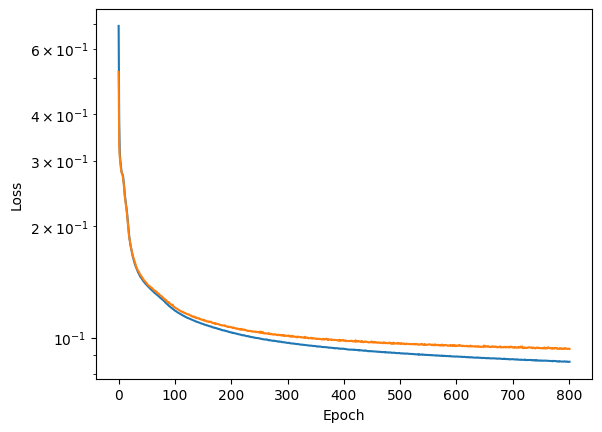

In [12]:
# plot loss vs. time
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

# Test

In [13]:
# embed and reconstruct all test images, for all possible bottleneck widths
test_data = test_dataset.data
recon_data = np.zeros_like(test_data)
recon_data = np.repeat(recon_data[:,None,...], repeats=model.latent_dim+1, axis=1)
with torch.no_grad():
    i = 0
    for j, batch_features in enumerate(test_loader):
        batch_features = batch_features.float().to(device)
        recon_data[i:i+len(batch_features)] = \
            itransform(model.forward_all(batch_features).detach().cpu()[:,:,0,...,None])
        i += len(batch_features)

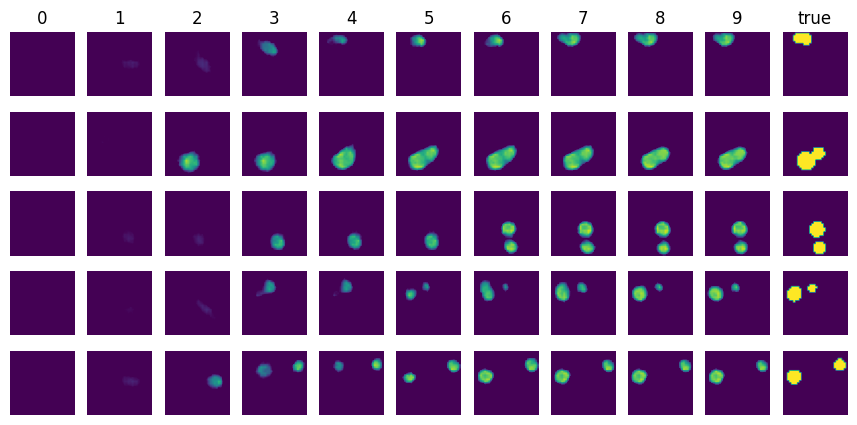

In [14]:
# show reconstruction examples, as a function of bottleneck width
N = 5
max_n_open = 9

f, axs = plt.subplots(N, max_n_open+2, figsize=(max_n_open*1.2, N))
inds = np.random.choice(len(test_data), size=N, replace=False)
for i in range(N):
    for j in range(max_n_open+1):
        axs[i,j].imshow(recon_data[inds[i], j], vmin=0, vmax=1)
        axs[i,j].axis('off')   
    
    axs[i,-1].imshow(test_data[inds[i]], vmin=0, vmax=1)
    axs[i,-1].axis('off')
        
axs[0,-1].set_title('true')
for j in range(max_n_open+1):
    axs[0,j].set_title(j)

Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

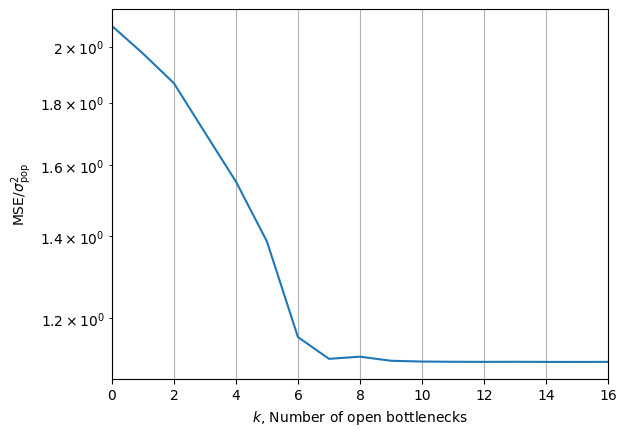

In [15]:
# calculate and plot the % variance explained, as a function of bottlneeck width
testvar = np.sum(np.var(test_data, axis=0).shape)
test_percerr = np.sum(np.mean((recon_data-test_data[:,None])**2, axis=0), axis=(1,2,3))/testvar

f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

# Calculate intrinsic dimensionality

In [24]:
# calculate intrinisic dimensionality

p = 0.05  # p-value at which to reject the null hypothesis
diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(diff_loglik<chi2.isf(p,1))[0,0]
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 7
